In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional, Flatten, TimeDistributed, Reshape
import tensorflow as tf


# **8:2**

In [82]:
df = pd.read_csv('Bnb.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,2019-03-02,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,2019-03-03,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,2019-03-04,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,2019-03-05,11.520388,13.841443,11.520388,13.811967,13.811967,237026335
...,...,...,...,...,...,...,...
1915,2024-05-28,603.526428,604.985107,593.716187,601.213257,601.213257,1852329404
1916,2024-05-29,601.213257,602.931519,592.966614,594.972046,594.972046,1642696946
1917,2024-05-30,594.972534,601.665039,586.557678,595.026794,595.026794,1737524745
1918,2024-05-31,595.026794,598.423645,589.774841,593.522339,593.522339,1590349553


In [83]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [84]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [85]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [86]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [87]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [88]:
# 8. Define LSTM Model
# Define the CNN model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [89]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
23/23 [==============================] - 4s 85ms/step - loss: 0.0467 - val_loss: 0.0168
Epoch 2/200
23/23 [==============================] - 3s 131ms/step - loss: 0.0136 - val_loss: 0.0170
Epoch 3/200
23/23 [==============================] - 2s 74ms/step - loss: 0.0097 - val_loss: 0.0109
Epoch 4/200
23/23 [==============================] - 2s 72ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 5/200
23/23 [==============================] - 2s 71ms/step - loss: 0.0050 - val_loss: 0.0077
Epoch 6/200
23/23 [==============================] - 2s 71ms/step - loss: 0.0047 - val_loss: 0.0068
Epoch 7/200
23/23 [==============================] - 2s 70ms/step - loss: 0.0041 - val_loss: 0.0062
Epoch 8/200
23/23 [==============================] - 2s 73ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 9/200
23/23 [==============================] - 3s 122ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 10/200
23/23 [==============================] - 2s 77ms/step - loss: 0.0033 - val_loss: 0.00

In [90]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 16ms/step


In [91]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [92]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 20.072491421836137
Testing MAPE: 3.8401339640859
Testing MAE: 14.515477749989689


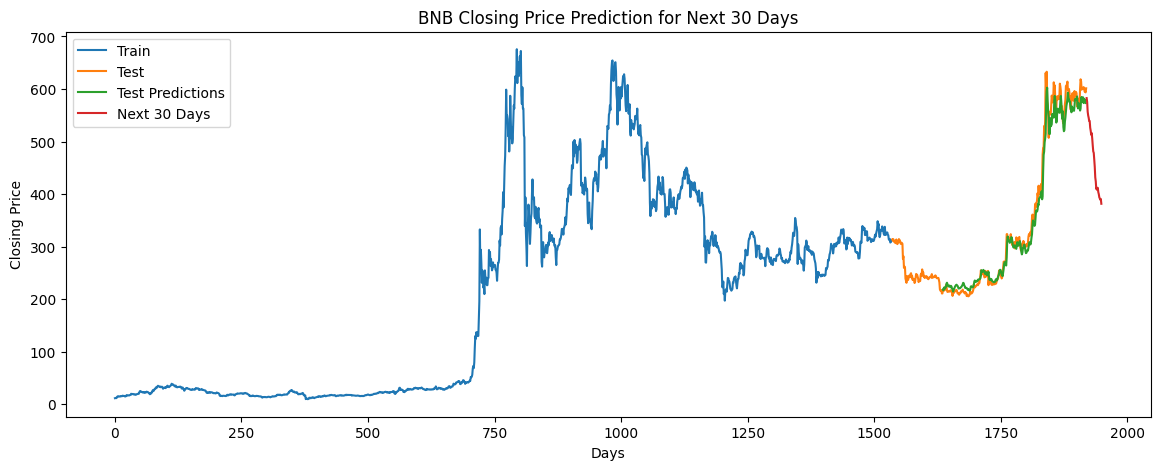

Predicted closing prices for the next 30 days:
[582.67804 575.3008  556.8081  549.5806  545.1343  539.1277  538.9339
 526.1507  520.3862  512.7838  516.09924 505.7637  492.8009  481.24634
 478.41064 465.65555 451.7825  431.6248  424.03424 409.50168 412.08646
 407.5089  411.80887 403.5557  399.7054  393.7179  391.6485  389.24173
 390.49402 381.4667 ]


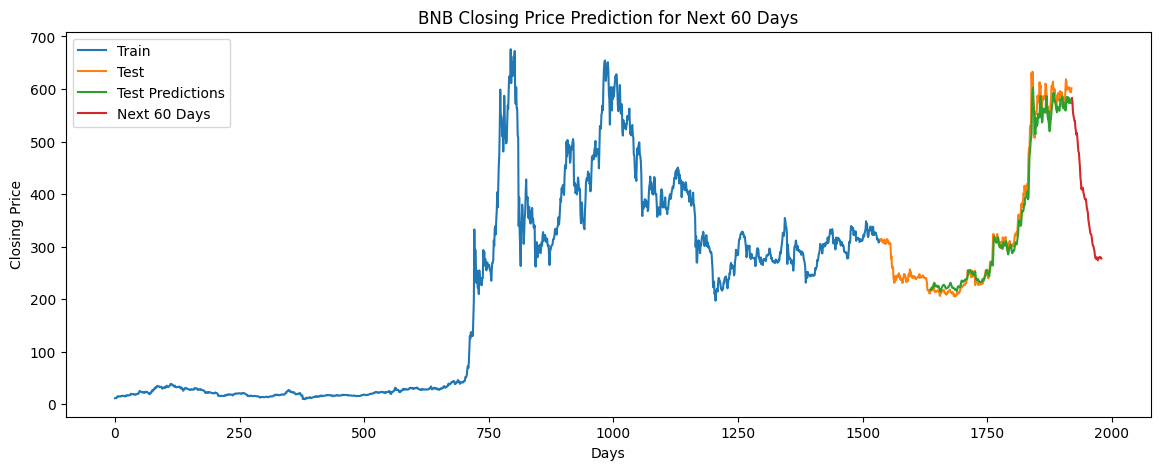

Predicted closing prices for the next 60 days:
[582.67804 575.3008  556.8081  549.5806  545.1343  539.1277  538.9339
 526.1507  520.3862  512.7838  516.09924 505.7637  492.8009  481.24634
 478.41064 465.65555 451.7825  431.6248  424.03424 409.50168 412.08646
 407.5089  411.80887 403.5557  399.7054  393.7179  391.6485  389.24173
 390.49402 381.4667  373.47144 368.968   364.3493  350.90887 344.5237
 338.3034  331.8448  325.14398 323.99716 321.78183 316.19464 307.14465
 301.91702 301.3064  296.46576 292.7745  284.09216 278.6019  276.87622
 279.00452 279.57986 276.2087  273.86636 277.93018 278.90637 279.78162
 278.45975 279.46497 279.33475 277.26956]


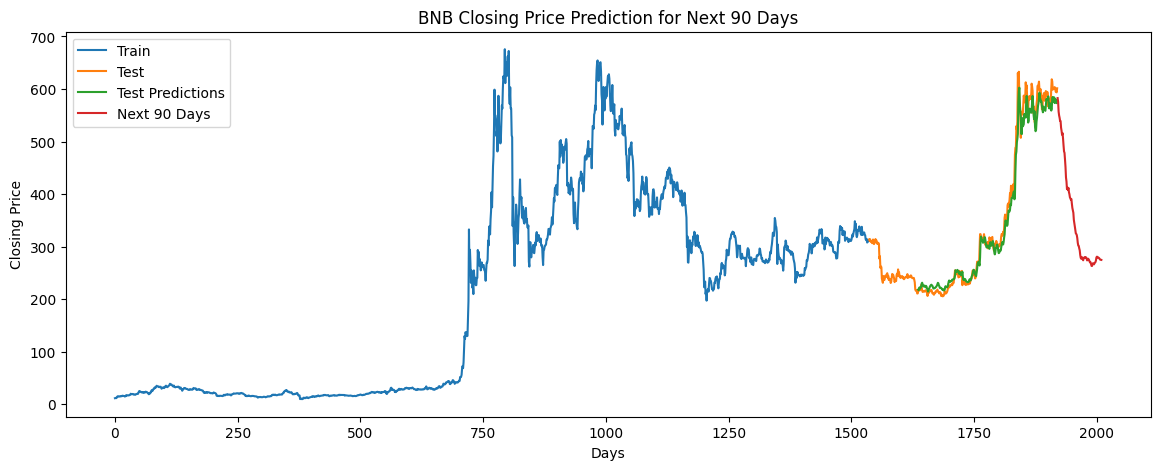

Predicted closing prices for the next 90 days:
[582.67804 575.3008  556.8081  549.5806  545.1343  539.1277  538.9339
 526.1507  520.3862  512.7838  516.09924 505.7637  492.8009  481.24634
 478.41064 465.65555 451.7825  431.6248  424.03424 409.50168 412.08646
 407.5089  411.80887 403.5557  399.7054  393.7179  391.6485  389.24173
 390.49402 381.4667  373.47144 368.968   364.3493  350.90887 344.5237
 338.3034  331.8448  325.14398 323.99716 321.78183 316.19464 307.14465
 301.91702 301.3064  296.46576 292.7745  284.09216 278.6019  276.87622
 279.00452 279.57986 276.2087  273.86636 277.93018 278.90637 279.78162
 278.45975 279.46497 279.33475 277.26956 273.68097 274.74747 276.8863
 275.95804 274.32263 271.66437 269.9895  270.27252 266.95996 263.27985
 262.96017 267.19717 268.23694 267.38715 266.10623 268.00723 269.37662
 270.44928 273.3897  279.2578  280.72635 280.24875 278.73724 278.8126
 278.45288 277.31952 275.78226 274.8765  274.85962 274.64267]


In [93]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'BNB Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **7:3**

In [94]:
df = pd.read_csv('Bnb.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,2019-03-02,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,2019-03-03,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,2019-03-04,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,2019-03-05,11.520388,13.841443,11.520388,13.811967,13.811967,237026335
...,...,...,...,...,...,...,...
1915,2024-05-28,603.526428,604.985107,593.716187,601.213257,601.213257,1852329404
1916,2024-05-29,601.213257,602.931519,592.966614,594.972046,594.972046,1642696946
1917,2024-05-30,594.972534,601.665039,586.557678,595.026794,595.026794,1737524745
1918,2024-05-31,595.026794,598.423645,589.774841,593.522339,593.522339,1590349553


In [95]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [96]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [97]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [98]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [99]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [100]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [101]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
20/20 [==============================] - 4s 94ms/step - loss: 0.0410 - val_loss: 0.0114
Epoch 2/200
20/20 [==============================] - 2s 76ms/step - loss: 0.0148 - val_loss: 0.0095
Epoch 3/200
20/20 [==============================] - 2s 76ms/step - loss: 0.0103 - val_loss: 0.0074
Epoch 4/200
20/20 [==============================] - 3s 138ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 5/200
20/20 [==============================] - 2s 78ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 6/200
20/20 [==============================] - 2s 76ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 7/200
20/20 [==============================] - 2s 76ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 8/200
20/20 [==============================] - 2s 78ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 9/200
20/20 [==============================] - 2s 77ms/step - loss: 0.0046 - val_loss: 0.0049
Epoch 10/200
20/20 [==============================] - 2s 77ms/step - loss: 0.0041 - val_loss: 0.003

In [102]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

15/15 [==============================] - 0s 13ms/step


In [103]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [104]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 22.37514516621005
Testing MAPE: 4.228935834392861
Testing MAE: 15.474031596936678


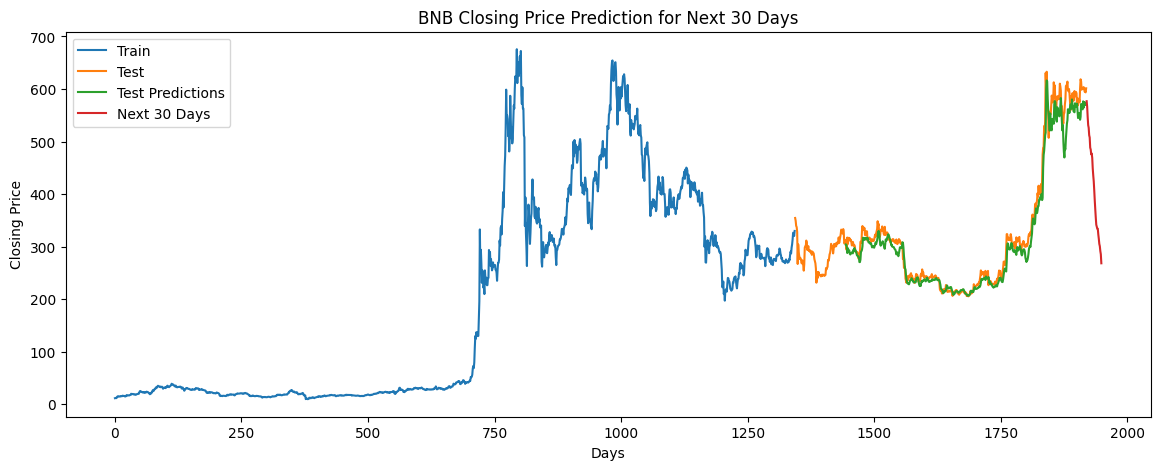

Predicted closing prices for the next 30 days:
[576.7113  566.4029  546.8954  531.24133 526.14056 511.91336 507.6681
 488.31268 484.6739  475.6613  477.1596  468.95    448.81738 435.58972
 424.21622 406.79434 387.8163  371.14127 355.26862 341.59467 337.7351
 333.99954 334.0085  323.14056 314.9442  305.03146 300.7859  291.4509
 285.33142 268.1646 ]


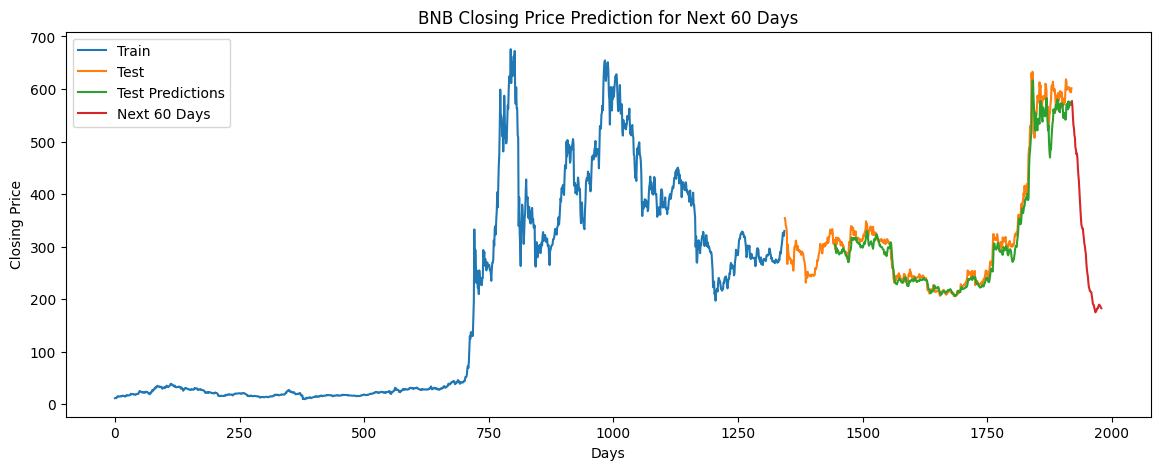

Predicted closing prices for the next 60 days:
[576.7113  566.4029  546.8954  531.24133 526.14056 511.91336 507.6681
 488.31268 484.6739  475.6613  477.1596  468.95    448.81738 435.58972
 424.21622 406.79434 387.8163  371.14127 355.26862 341.59467 337.7351
 333.99954 334.0085  323.14056 314.9442  305.03146 300.7859  291.4509
 285.33142 268.1646  256.73422 248.40553 243.15527 231.371   223.01453
 219.83333 215.53981 215.15038 213.67772 213.01035 205.5481  198.8776
 191.129   189.16507 188.55824 182.84389 179.4206  174.7467  176.08534
 177.45291 181.92714 181.8103  182.29381 185.86801 188.50664 189.54948
 186.94548 186.41158 183.92123 182.7418 ]


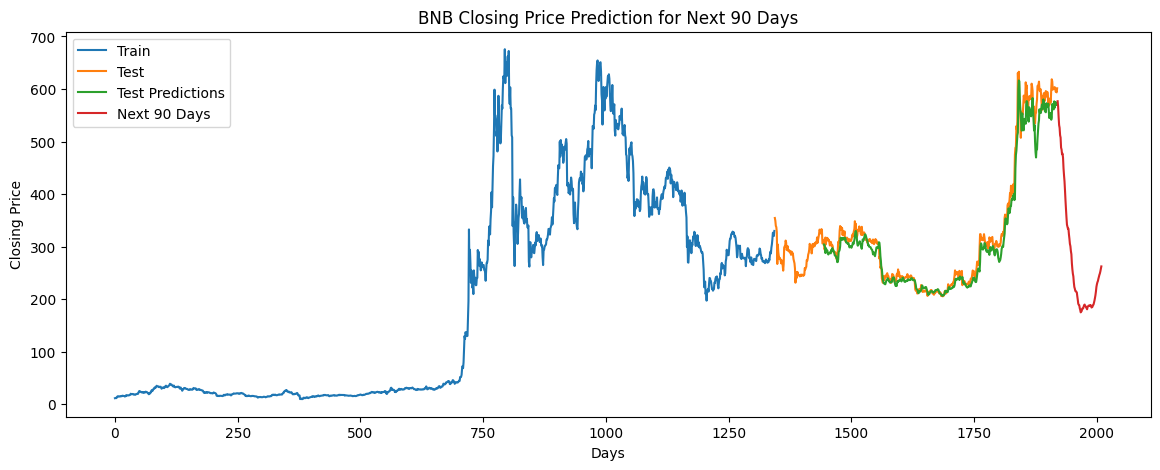

Predicted closing prices for the next 90 days:
[576.7113  566.4029  546.8954  531.24133 526.14056 511.91336 507.6681
 488.31268 484.6739  475.6613  477.1596  468.95    448.81738 435.58972
 424.21622 406.79434 387.8163  371.14127 355.26862 341.59467 337.7351
 333.99954 334.0085  323.14056 314.9442  305.03146 300.7859  291.4509
 285.33142 268.1646  256.73422 248.40553 243.15527 231.371   223.01453
 219.83333 215.53981 215.15038 213.67772 213.01035 205.5481  198.8776
 191.129   189.16507 188.55824 182.84389 179.4206  174.7467  176.08534
 177.45291 181.92714 181.8103  182.29381 185.86801 188.50664 189.54948
 186.94548 186.41158 183.92123 182.7418  180.57646 184.84274 186.3141
 187.60866 187.0125  187.51723 186.9503  188.7576  187.01762 183.99011
 184.68166 185.45384 188.63242 189.30602 192.95674 197.03766 201.96812
 207.45665 214.52005 223.28972 228.27415 232.0033  234.34198 238.6388
 242.25134 246.00038 248.74506 252.68802 257.54626 262.2169 ]


In [105]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'BNB Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **6:4**

In [106]:
df = pd.read_csv('Bnb.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,2019-03-02,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,2019-03-03,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,2019-03-04,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,2019-03-05,11.520388,13.841443,11.520388,13.811967,13.811967,237026335
...,...,...,...,...,...,...,...
1915,2024-05-28,603.526428,604.985107,593.716187,601.213257,601.213257,1852329404
1916,2024-05-29,601.213257,602.931519,592.966614,594.972046,594.972046,1642696946
1917,2024-05-30,594.972534,601.665039,586.557678,595.026794,595.026794,1737524745
1918,2024-05-31,595.026794,598.423645,589.774841,593.522339,593.522339,1590349553


In [107]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [108]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [109]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [110]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [111]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [112]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [113]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
17/17 [==============================] - 4s 101ms/step - loss: 0.0581 - val_loss: 0.0360
Epoch 2/200
17/17 [==============================] - 2s 125ms/step - loss: 0.0216 - val_loss: 0.0190
Epoch 3/200
17/17 [==============================] - 2s 131ms/step - loss: 0.0159 - val_loss: 0.0078
Epoch 4/200
17/17 [==============================] - 1s 83ms/step - loss: 0.0120 - val_loss: 0.0067
Epoch 5/200
17/17 [==============================] - 1s 82ms/step - loss: 0.0090 - val_loss: 0.0059
Epoch 6/200
17/17 [==============================] - 1s 82ms/step - loss: 0.0069 - val_loss: 0.0057
Epoch 7/200
17/17 [==============================] - 1s 84ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 8/200
17/17 [==============================] - 1s 82ms/step - loss: 0.0056 - val_loss: 0.0066
Epoch 9/200
17/17 [==============================] - 1s 83ms/step - loss: 0.0048 - val_loss: 0.0054
Epoch 10/200
17/17 [==============================] - 2s 89ms/step - loss: 0.0042 - val_loss: 0.0

In [114]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

21/21 [==============================] - 0s 14ms/step


In [115]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [116]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 25.09445398386283
Testing MAPE: 7.673811914172454
Testing MAE: 21.300665264901756


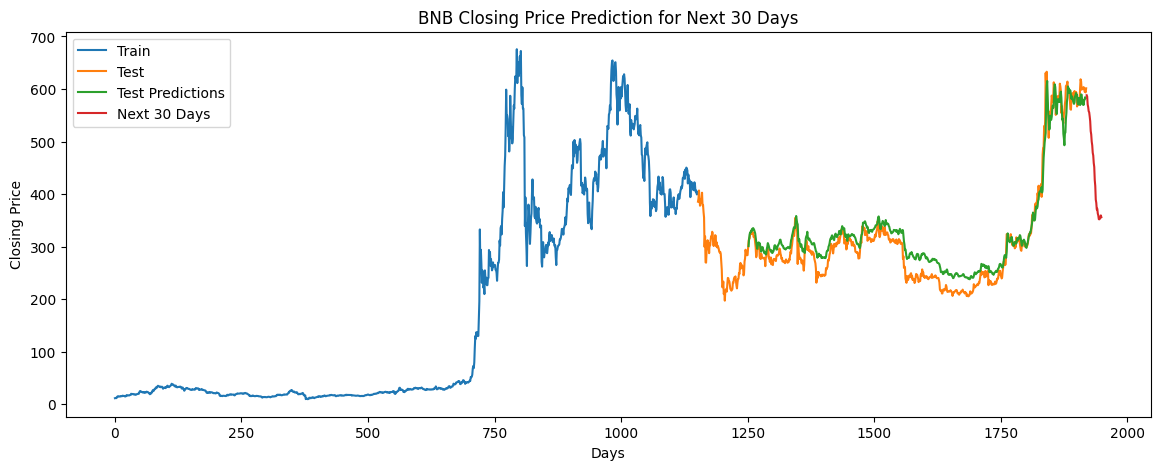

Predicted closing prices for the next 30 days:
[588.07007 585.7569  570.38525 565.59546 557.6956  555.5807  547.73083
 538.683   519.8537  513.4781  499.76593 492.82108 478.56772 473.42468
 459.04727 451.50113 426.61636 415.49765 389.42307 383.3387  370.62048
 372.09427 362.79205 359.3118  352.13055 351.88074 352.94446 354.39383
 359.35046 356.00552]


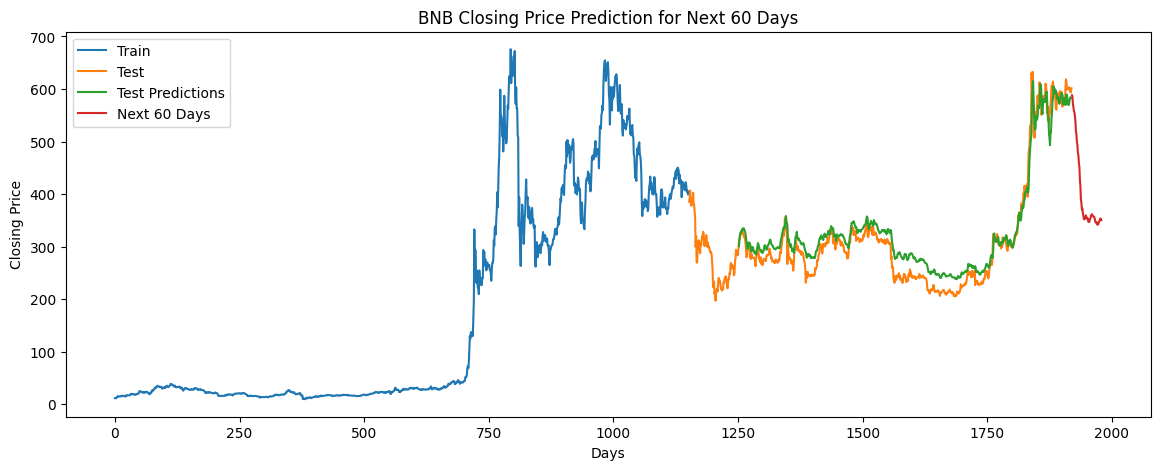

Predicted closing prices for the next 60 days:
[588.07007 585.7569  570.38525 565.59546 557.6956  555.5807  547.73083
 538.683   519.8537  513.4781  499.76593 492.82108 478.56772 473.42468
 459.04727 451.50113 426.61636 415.49765 389.42307 383.3387  370.62048
 372.09427 362.79205 359.3118  352.13055 351.88074 352.94446 354.39383
 359.35046 356.00552 354.72272 352.09933 353.4714  347.05472 346.97583
 347.03296 351.36835 353.53278 358.03665 360.49744 361.48376 359.54077
 358.64227 357.16934 357.09286 355.8321  351.86783 346.44907 345.95294
 344.8122  346.10483 341.44226 342.4763  342.80765 346.72818 348.06195
 351.31998 353.48703 352.60788 350.45367]


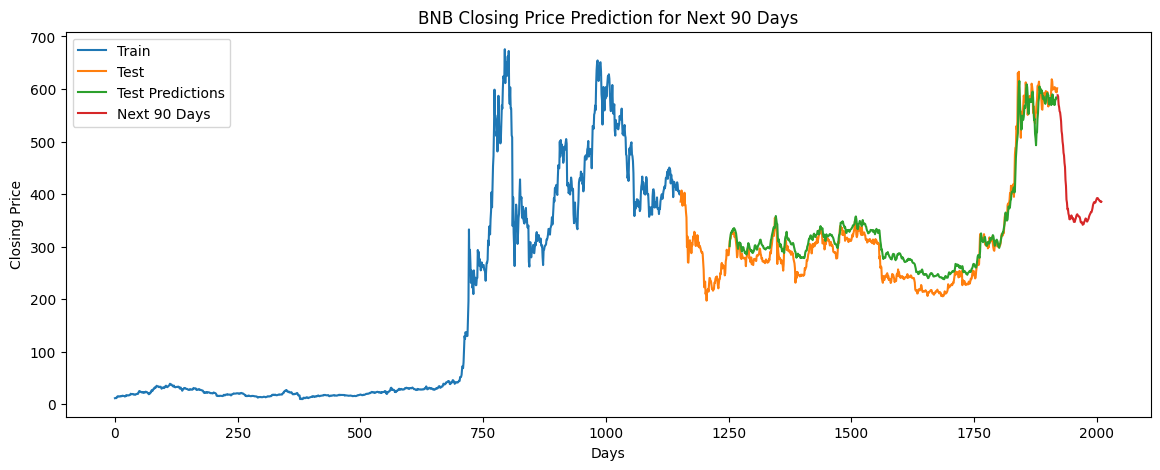

Predicted closing prices for the next 90 days:
[588.07007 585.7569  570.38525 565.59546 557.6956  555.5807  547.73083
 538.683   519.8537  513.4781  499.76593 492.82108 478.56772 473.42468
 459.04727 451.50113 426.61636 415.49765 389.42307 383.3387  370.62048
 372.09427 362.79205 359.3118  352.13055 351.88074 352.94446 354.39383
 359.35046 356.00552 354.72272 352.09933 353.4714  347.05472 346.97583
 347.03296 351.36835 353.53278 358.03665 360.49744 361.48376 359.54077
 358.64227 357.16934 357.09286 355.8321  351.86783 346.44907 345.95294
 344.8122  346.10483 341.44226 342.4763  342.80765 346.72818 348.06195
 351.31998 353.48703 352.60788 350.45367 347.4613  348.9756  351.31088
 352.8422  357.1009  359.74728 361.75644 363.78165 365.59827 365.5892
 368.8786  373.      378.81247 381.8012  384.25342 383.27844 384.47543
 383.93436 387.09442 389.45648 392.1261  392.4354  391.87042 389.9035
 389.12845 387.35504 387.1524  385.4949  386.3954  385.44897]


In [117]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'BNB Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())